#Training CNN


In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2

data = np.load('/content/character_font.npz')
print(data.keys())

X = data['images']
y = data['labels']
X = X[:100000]
y = y[:100000]
X = X / 255.0

X_resized = np.zeros((X.shape[0], 28, 28), dtype=X.dtype)
for i in range(X.shape[0]):
    X_resized[i] = cv2.resize(X[i], (28, 28))
X = X_resized.reshape(-1, 28, 28, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(26, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

model.save('character_model_new.h5')
print("Model berhasil disimpan")

KeysView(NpzFile '/content/character_font (1).npz' with keys: images, labels)
Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.6756 - loss: 1.2303 - val_accuracy: 0.8109 - val_loss: 0.7263
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 78s 30ms/step - accuracy: 0.8257 - loss: 0.6681 - val_accuracy: 0.8303 - val_loss: 0.6458
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - accuracy: 0.8470 - loss: 0.5683 - val_accuracy: 0.8378 - val_loss: 0.6011
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - accuracy: 0.8635 - loss: 0.4994 - val_accuracy: 0.8486 - val_loss: 0.5797
Epoch 5/10
2485/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8780 - loss: 0.4426

# Testing OCR1

Ditemukan 1 karakter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Karakter 1: Posisi (0,0) Size (1327x745) -> T
Predicted Text: T


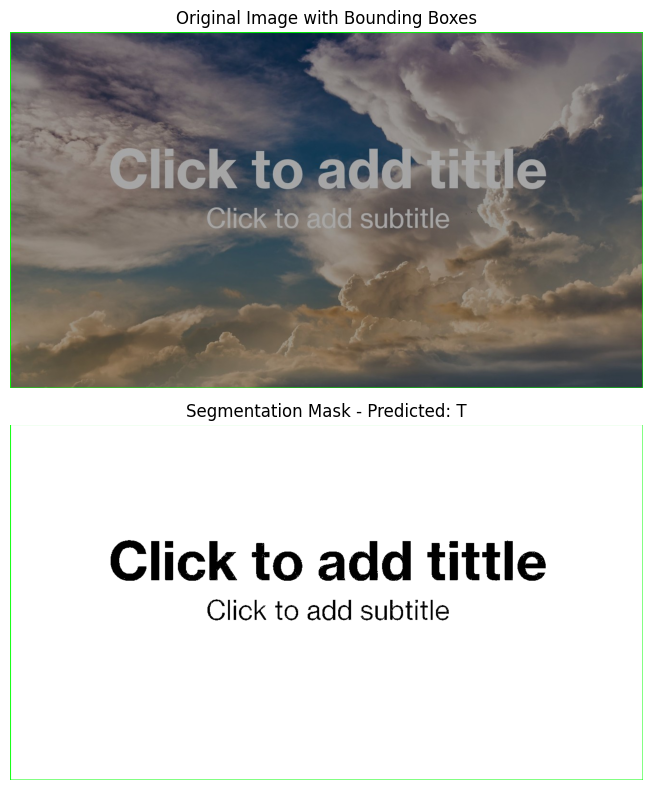

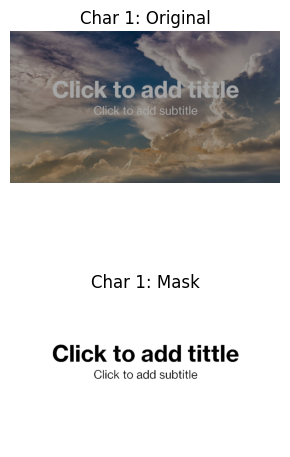

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib

model = load_model("/content/character_model.h5")

img = cv2.imread("/content/ocr1.jpg")

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if img is None:
    print("Error: Image not loaded. Please check the image path.")
else:
    _, mask_dark = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY_INV)
    lower_yellow = np.array([20, 50, 50])
    upper_yellow = np.array([40, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_letters2 = cv2.bitwise_or(mask_dark, mask_yellow)

    kernel_erode = np.ones((2,2), np.uint8)
    mask_eroded = cv2.erode(mask_letters2, kernel_erode, iterations=1)
    kernel_dilate = np.ones((1,1), np.uint8)
    mask_processed = cv2.dilate(mask_eroded, kernel_dilate, iterations=1)

    def filter_and_split_contours(mask, min_area=100, max_width_ratio=3.0):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        char_boxes = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = cv2.contourArea(cnt)
            if area < min_area or h < 15 or w < 8:
                continue
            aspect_ratio = w / h
            if aspect_ratio > max_width_ratio:
                num_chars = int(np.round(aspect_ratio / 1.2))
                char_width = w // num_chars
                for i in range(num_chars):
                    new_x = x + i * char_width
                    new_w = w - i * char_width if i == num_chars - 1 else char_width
                    roi = mask[y:y+h, new_x:new_x+new_w]
                    if roi.shape[0] > 0 and roi.shape[1] > 0 and np.sum(roi) > min_area * 10:
                        char_boxes.append((new_x, y, new_w, h))
            else:
                char_boxes.append((x, y, w, h))
        return char_boxes

    def remove_duplicates_and_filter(boxes):
        filtered = []
        boxes_sorted_by_area = sorted(boxes, key=lambda b: b[2]*b[3], reverse=True)

        for i in range(len(boxes_sorted_by_area)):
            x1, y1, w1, h1 = boxes_sorted_by_area[i]
            is_duplicate = False
            for j in range(len(boxes_sorted_by_area)):
                if i != j:
                    x2, y2, w2, h2 = boxes_sorted_by_area[j]
                    x_overlap = max(0, min(x1+w1, x2+w2) - max(x1, x2))
                    y_overlap = max(0, min(y1+h1, y2+h2) - max(y1, y2))
                    intersection = x_overlap * y_overlap
                    area1 = w1 * h1
                    area2 = w2 * h2

                    if area1 > 0 and intersection / area1 > 0.7:
                         if area1 < area2:
                            is_duplicate = True
                            break

            if not is_duplicate:
                filtered.append((x1, y1, w1, h1))

        filtered = sorted(filtered, key=lambda b: b[0])
        return filtered

    char_boxes = filter_and_split_contours(mask_processed)
    char_boxes = remove_duplicates_and_filter(char_boxes)
    char_boxes = sorted(char_boxes, key=lambda b: b[0])
    print(f"Ditemukan {len(char_boxes)} karakter")

    hasil = ""
    for i, (x, y, w, h) in enumerate(char_boxes):
        char_img = mask_letters2[y:y+h, x:x+w]
        char_img = 255 - char_img

        resized = cv2.resize(char_img, (28, 28))
        norm = resized.astype(np.float32) / 255.0
        reshaped = norm.reshape(1, 28, 28, 1)
        label = model.predict(reshaped)
        label = np.argmax(label) if label.shape[-1] > 1 else int(np.round(label[0][0]))
        huruf = chr(int(label) + ord('A'))
        hasil += huruf
        print(f"Karakter {i+1}: Posisi ({x},{y}) Size ({w}x{h}) -> {huruf}")

    print("Predicted Text:", hasil)

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    img_vis = img.copy()
    for i, (x, y, w, h) in enumerate(char_boxes):
        cv2.rectangle(img_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_vis, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    axes[0].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image with Bounding Boxes")
    axes[0].axis("off")

    mask_vis = cv2.cvtColor(mask_letters2, cv2.COLOR_GRAY2BGR)
    for i, (x, y, w, h) in enumerate(char_boxes):
        cv2.rectangle(mask_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(mask_vis, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    axes[1].imshow(cv2.cvtColor(mask_vis, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Segmentation Mask - Predicted: {hasil}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    num_chars_to_show = min(len(char_boxes), 10)
    if num_chars_to_show > 0:
        fig, axes = plt.subplots(2, num_chars_to_show, figsize=(3*num_chars_to_show, 6))
        if num_chars_to_show == 1:
            axes = axes.reshape(-1, 1)

        for i in range(num_chars_to_show):
            x, y, w, h = char_boxes[i]
            roi_orig = img[y:y+h, x:x+w]
            axes[0, i].imshow(cv2.cvtColor(roi_orig, cv2.COLOR_BGR2RGB))
            axes[0, i].set_title(f"Char {i+1}: Original")
            axes[0, i].axis("off")
            roi_mask = mask_letters2[y:y+h, x:x+w]
            axes[1, i].imshow(roi_mask, cmap='gray')
            axes[1, i].set_title(f"Char {i+1}: Mask")
            axes[1, i].axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print("No characters detected to show individual ROIs.")

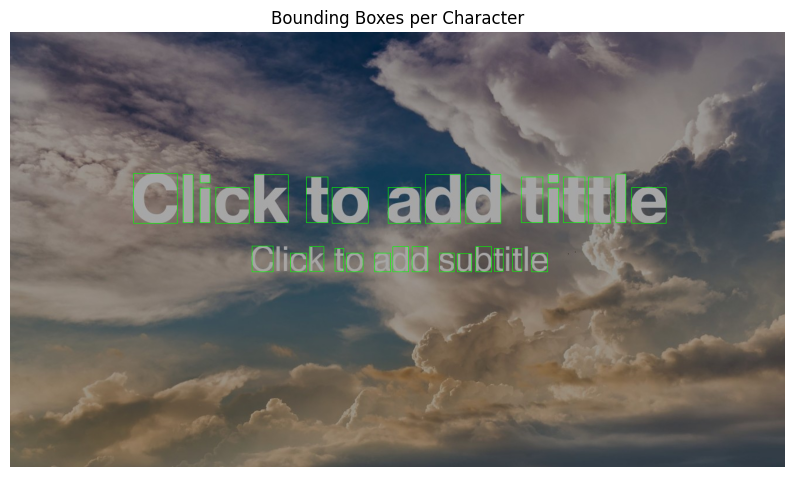

In [ ]:
import cv2
import matplotlib.pyplot as plt

gray_mask = mask_letters2
_, thresh = cv2.threshold(gray_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bounding_boxes = []
output_image = img.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 5 and h > 10:
        bounding_boxes.append((x, y, w, h))
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

bounding_boxes = sorted(bounding_boxes, key=lambda b: (b[1] // 10, b[0]))

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Bounding Boxes per Character")
plt.axis("off")
plt.show()

Model CNN berhasil dimuat.

Memulai prediksi untuk 32 karakter...

--- Hasil Prediksi Teks ---
CI J K ? DD ?J??IIC OA I E
C K DD WC TO Q S ? TEU


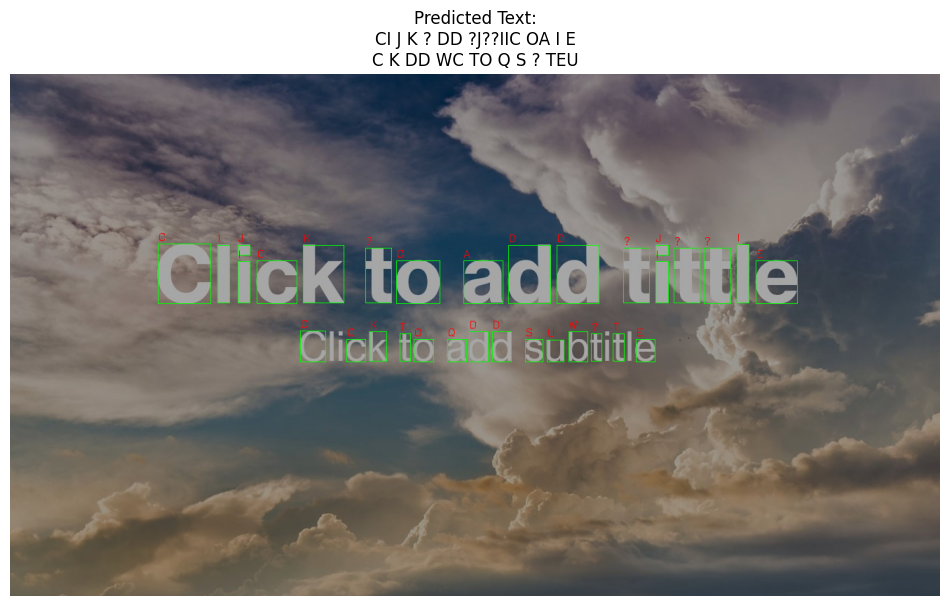

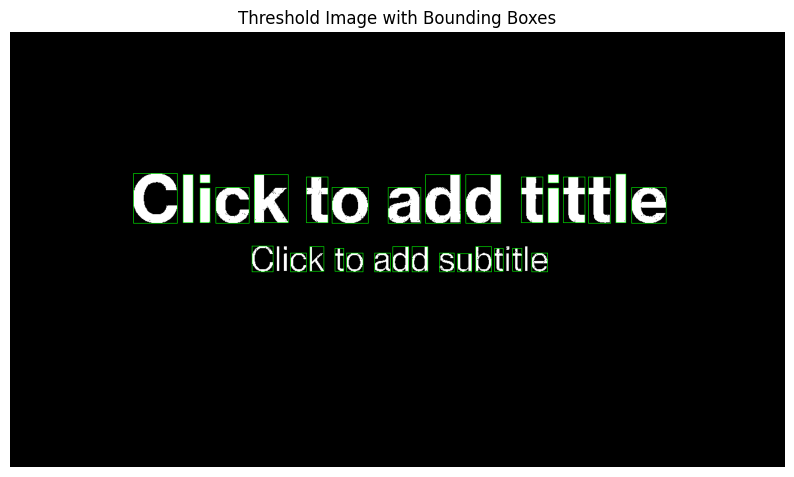

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model # Import load_model

def show_image(title, img):
    plt.figure(figsize=(10, 6))
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

image_path = gray_mask

gray_mask = mask_letters2
_, thresh = cv2.threshold(gray_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bounding_boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 5 and h > 10 and h < gray_mask.shape[0] * 0.8 and w < gray_mask.shape[1] * 0.8:
        bounding_boxes.append((x, y, w, h))

bounding_boxes = sorted(bounding_boxes, key=lambda b: (b[1] // 10, b[0]))


try:
    model = load_model("/content/character_model.h5")
    print("Model CNN berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat model CNN: {e}")
    model = None

hasil_prediksi = ""
prev_x = None
prev_y = None

if model is not None:
    char_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
        10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T',
        20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}

    print(f"\nMemulai prediksi untuk {len(bounding_boxes)} karakter...")
    for i, (x, y, w, h) in enumerate(bounding_boxes):
        if prev_y is not None and (y - prev_y) > (h * 0.8):
            if prev_x is not None and (x - (prev_x + prev_w)) > (w * 0.5):
                 hasil_prediksi += " "
            hasil_prediksi += "\n"
        elif prev_x is not None and (x - (prev_x + prev_w)) > (w * 0.7):
             hasil_prediksi += " "

        char_img = thresh[y:y+h, x:x+w]

        try:
            target_size = 28
            if w > h:
                new_w = int(target_size * 0.7)
                new_h = int(h * new_w / w)
            else:
                new_h = int(target_size * 0.7)
                new_w = int(w * new_h / h)

            if new_w <= 0: new_w = 1
            if new_h <= 0: new_h = 1
            resized = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_AREA)

            top = (target_size - resized.shape[0]) // 2
            bottom = target_size - resized.shape[0] - top
            left = (target_size - resized.shape[1]) // 2
            right = target_size - resized.shape[1] - left
            top = max(0, top)
            bottom = max(0, bottom)
            left = max(0, left)
            right = max(0, right)

            padded = cv2.copyMakeBorder(resized, top, bottom, left, right,cv2.BORDER_CONSTANT, value=0)
            if padded.shape[0] != target_size or padded.shape[1] != target_size:
                 print(f"Warning: Padding failed for char {i}, forcing resize.")
                 padded = cv2.resize(padded, (target_size, target_size), interpolation=cv2.INTER_AREA)

            norm = padded.astype(np.float32) / 255.0
            reshaped = norm.reshape(1, target_size, target_size, 1)

            pred = model.predict(reshaped, verbose=0)
            label_idx = np.argmax(pred)
            if confidence > 0.5 and label_idx in char_mapping:
                 huruf = char_mapping[label_idx]
            else:
                 huruf = "?"
            hasil_prediksi += huruf

            prev_x = x
            prev_y = y
            prev_w = w

        except Exception as e:
            print(f"Error memproses karakter di box ({x},{y},{w},{h}): {e}")
            hasil_prediksi += "?"

    print("\n--- Hasil Prediksi Teks ---")
    print(hasil_prediksi)

output_image = img.copy()
predicted_chars_list = list(hasil_prediksi.replace('\n', ' ').replace(' ', ''))
char_idx = 0

for i, (x, y, w, h) in enumerate(bounding_boxes):
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    if char_idx < len(predicted_chars_list):
         predicted_char = predicted_chars_list[char_idx]
         cv2.putText(output_image, predicted_char, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
         char_idx += 1

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Text:\n{hasil_prediksi}")
plt.axis("off")
plt.show()

img_thresh_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for x, y, w, h in bounding_boxes:
     cv2.rectangle(img_thresh_vis, (x, y), (x + w, y + h), (0, 255, 0), 1)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_thresh_vis, cv2.COLOR_BGR2RGB))
plt.title("Threshold Image with Bounding Boxes")
plt.axis("off")
plt.show()

#Testing OCR2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Text: ZGJSZV


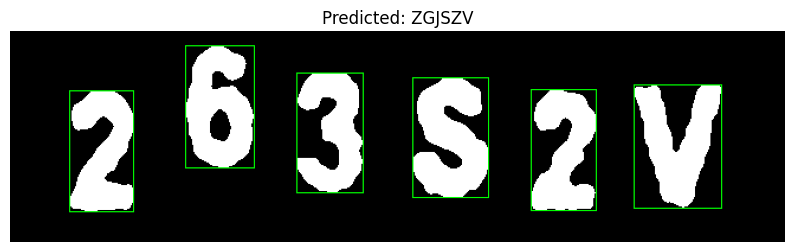

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

img = cv2.imread("ocr2.jpg", cv2.IMREAD_GRAYSCALE)

gaussian = cv2.GaussianBlur(img, (5, 5), 0)
nlm = cv2.fastNlMeansDenoising(gaussian, None, 30, 7, 21)
bilateral_filtered = cv2.bilateralFilter(nlm, d=9, sigmaColor=75, sigmaSpace=75)
_, thresh = cv2.threshold(bilateral_filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

char_boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 10 and w > 5:
        char_boxes.append((x, y, w, h))
char_boxes = sorted(char_boxes, key=lambda b: b[0])

model = load_model("/content/character_model.h5")
hasil = ""
for x, y, w, h in char_boxes:
    char_img = thresh[y:y+h, x:x+w]
    resized = cv2.resize(char_img, (28, 28))
    norm = resized / 255.0
    reshaped = norm.reshape(1, 28, 28, 1)
    pred = model.predict(reshaped)
    label = np.argmax(pred)
    huruf = chr(label + ord('A'))
    hasil += huruf
print("Predicted Text:", hasil)

img_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for x, y, w, h in char_boxes:
    cv2.rectangle(img_vis, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.figure(figsize=(10, 4))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {hasil}")
plt.axis("off")
plt.show()


#Testing OCR3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


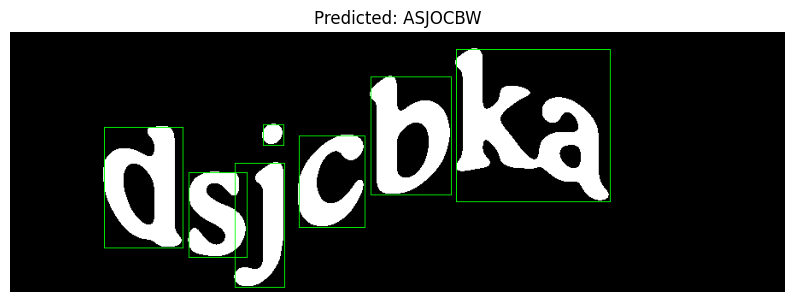

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

img_path = "/content/ocr3.jpg"
image = cv2.imread(img_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
denoised = cv2.fastNlMeansDenoising(gray, h=30)
_, thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

char_boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 10 and w > 5:
        char_boxes.append((x, y, w, h))
char_boxes = sorted(char_boxes, key=lambda b: b[0])

model = load_model("/content/character_model.h5")
hasil = ""
for x, y, w, h in char_boxes:
    char_img = thresh[y:y+h, x:x+w]
    resized = cv2.resize(char_img, (28, 28))
    norm = resized / 255.0
    reshaped = norm.reshape(1, 28, 28, 1)
    pred = model.predict(reshaped)
    label = np.argmax(pred)
    huruf = chr(label + ord('A'))
    hasil += huruf

img_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for x, y, w, h in char_boxes:
    cv2.rectangle(img_vis, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.figure(figsize=(10, 4))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {hasil}")
plt.axis("off")
plt.show()

#Testing OCR4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted Text: ANWE


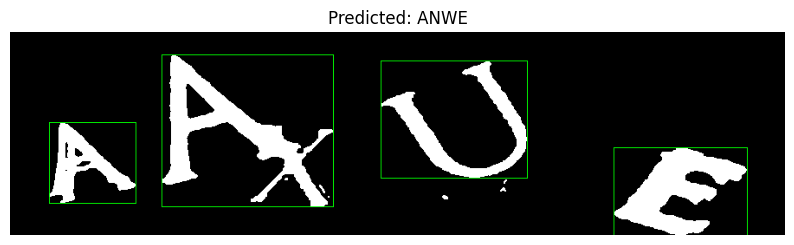

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/ocr4.jpg')

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask_dark = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY_INV)
lower_yellow = np.array([20, 50, 50])
upper_yellow = np.array([40, 255, 255])
mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
mask_letters = cv2.bitwise_or(mask_dark, mask_yellow)
kernel = np.ones((2,2), np.uint8)
mask_letters = cv2.morphologyEx(mask_letters, cv2.MORPH_OPEN, kernel)

contours, _ = cv2.findContours(mask_letters, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
char_boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 10 and w > 10:
        char_boxes.append((x, y, w, h))

char_boxes = sorted(char_boxes, key=lambda b: b[0])

model = load_model("/content/character_model.h5")
hasil = ""
for x, y, w, h in char_boxes:
    char_img = mask_letters[y:y+h, x:x+w]
    resized = cv2.resize(char_img, (28, 28))
    norm = resized / 255.0
    reshaped = norm.reshape(1, 28, 28, 1)
    pred = model.predict(reshaped)
    label = np.argmax(pred)
    huruf = chr(label + ord('A'))
    hasil += huruf

print("Predicted Text:", hasil)

img_vis = cv2.cvtColor(mask_letters, cv2.COLOR_GRAY2BGR)
for x, y, w, h in char_boxes:
    cv2.rectangle(img_vis, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.figure(figsize=(10, 4))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {hasil}")
plt.axis("off")
plt.show()

#Testing OCR5

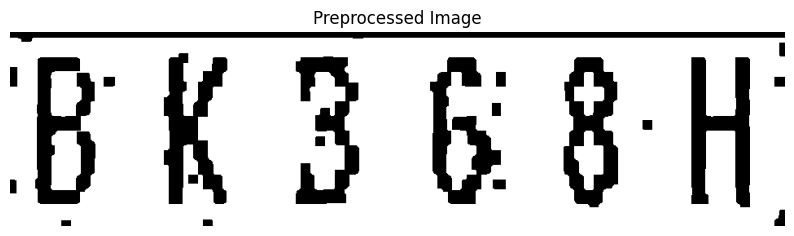

Predicted Text (CNN): KKBCBH


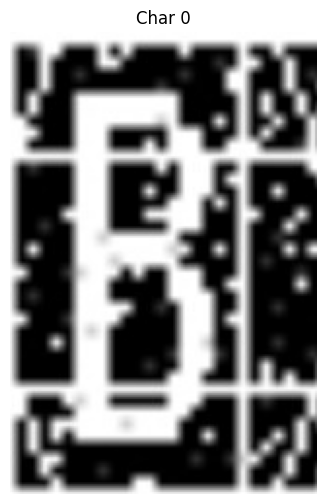

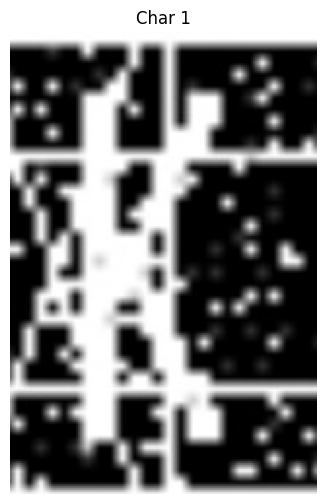

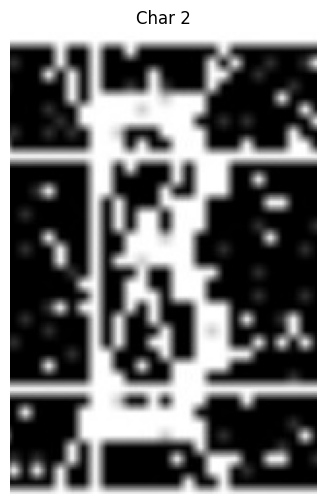

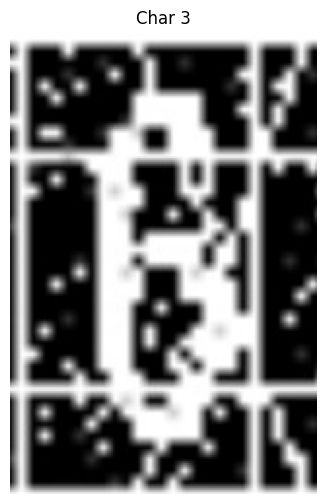

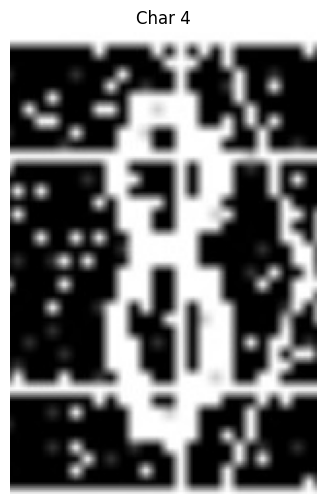

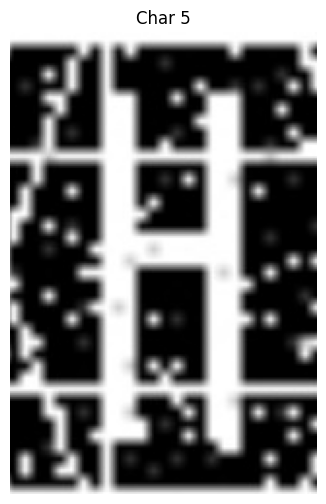

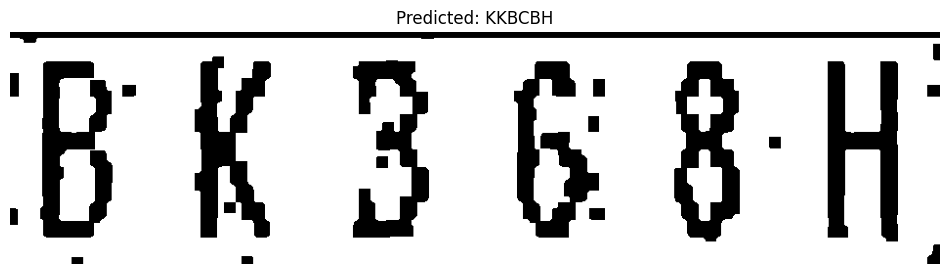

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def show_image(title, img):
    plt.figure(figsize=(10, 6))
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


model = load_model("/content/character_model.h5")

img_path = '/content/ocr5.jpg'
image = cv2.imread(img_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
equalized = cv2.equalizeHist(gray)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
enhanced = clahe.apply(equalized)
blurred = cv2.medianBlur(enhanced, 3)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilate = cv2.dilate(thresh, kernel, iterations=6)
eroded = cv2.erode(dilate, kernel, iterations=5)
show_image("Preprocessed Image", eroded)

num_chars = 6
h, w = eroded.shape
char_width = w // num_chars
char_boxes = [(i * char_width, 0, char_width, h) for i in range(num_chars)]

hasil = ""
for i, (x, y, w, h) in enumerate(char_boxes):
    char_img = eroded[y:y+h, x:x+w]
    char_img = 255 - char_img

    h0, w0 = char_img.shape
    pad = int(max(h0, w0) * 0.1)
    padded = np.pad(char_img, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)
    resized = cv2.resize(padded, (28, 28))

    input_img = resized.astype("float32") / 255.0
    input_img = np.expand_dims(input_img, axis=-1)
    input_img = np.expand_dims(input_img, axis=0)
    pred = model.predict(input_img, verbose=0)
    label = np.argmax(pred)

    huruf = chr(label + ord('A'))
    hasil += huruf

print("Predicted Text (CNN):", hasil)

img_vis = cv2.cvtColor(eroded, cv2.COLOR_GRAY2BGR)
for i, (x, y, w, h) in enumerate(char_boxes):
    char_crop = image[y:y+h, x:x+w]
    show_image(f"Char {i}", char_crop)

plt.figure(figsize=(12, 4))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {hasil}")
plt.axis("off")
plt.show()